In [2]:
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
library(cmprsk)
library(ggrepel)
options(warn=-1)
source("../../../src/tools.R")
source("../../script_figures/tools.R")

library(mstate)
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

# Initial Data

In [3]:
df <- read.table('../../clustering/clustering_Final_1/df_final_full_component.tsv')

all_gen <- c(5:88)
vect <- apply(X=df[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df)[1])
gen <- colnames(df[,match(names(vect[vect>=2]),names(df))])

all_cyto <- c(89:158)
vect <- apply(X=df[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df)[1])
cyto <- colnames(df[,match(names(vect[vect>=2]),names(df))])       
              
comp <- colnames(df)[170:185]

clin <- colnames(df)[c(159:165)]
demo <- colnames(df)[166:167]
master <- read.table('../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
tmp <- merge(df[,c(comp,gen,cyto,clin,demo)],master[,c("os","os_status","RelapseCIStatus","OS_CR","RFSyears")],by=0)
rownames(tmp) <- tmp$Row.names
tmp$patient_id <- tmp$Row.names

# Classic Model

In [4]:
# Remove weird cases (11) : we do not know when they have relapsed or CR


tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & is.na(tmp$OS_CR)),]
tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & tmp$os_status==1 & tmp$RFSyears > tmp$OS_CR),]   # you can not relapse from CR  after you die !!!
tmp <- tmp[!(tmp$RFSyears==0 & !is.na(tmp$RFSyears)),]  ### remove when Relapse is exactly 0!


# Handle CR

tmp$CR_stat <- ifelse(is.na(tmp$OS_CR),0,1)
tmp[is.na(tmp$OS_CR),"CR"] <- tmp[is.na(tmp$OS_CR),"os"]
tmp[!is.na(tmp$OS_CR),"CR"]<- tmp[!is.na(tmp$OS_CR),"os"] - tmp[!is.na(tmp$OS_CR),"OS_CR"]

# Handle RFS (relapse from first CR)

tmp$Relapse_stat <- ifelse(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus),1,0)
tmp$Relapse <- tmp$os
tmp[tmp$Relapse_stat==1,"Relapse"] <- tmp[tmp$Relapse_stat==1,"CR"] + tmp[tmp$Relapse_stat==1,"RFSyears"]

tmp$OS <- tmp$os
tmp$OS_stat <- tmp$os_status



# Advanced Model

In [5]:
# Remove weird cases (11) : we do not know when they have relapsed or CR


tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & is.na(tmp$OS_CR)),]
tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & tmp$os_status==1 & tmp$RFSyears > tmp$OS_CR),]   # you can not relapse from CR  after you die !!!
tmp <- tmp[!(tmp$RFSyears==0 & !is.na(tmp$RFSyears)),]  ### remove when Relapse is exactly 0!


# Handle CR

tmp$CR_stat <- ifelse(is.na(tmp$OS_CR),0,1)
tmp[is.na(tmp$OS_CR),"CR"] <- tmp[is.na(tmp$OS_CR),"os"]
tmp[!is.na(tmp$OS_CR),"CR"]<- tmp[!is.na(tmp$OS_CR),"os"] - tmp[!is.na(tmp$OS_CR),"OS_CR"]

# Handle RFS (relapse from first CR)

tmp$Relapse_stat <- ifelse(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus),1,0)
tmp$Relapse <- tmp$os
tmp[tmp$Relapse_stat==1,"Relapse"] <- tmp[tmp$Relapse_stat==1,"CR"] + tmp[tmp$Relapse_stat==1,"RFSyears"]

tmp$OS <- tmp$os
tmp$OS_stat <- tmp$os_status

tmp$Death_in_CR <- tmp$OS
tmp$Death_in_CR_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

tmp$Death_in_CR <- tmp$OS
tmp$Death_in_CR_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

tmp$Death_in_Relapse <- tmp$OS
tmp$Death_in_Relapse_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==1 & tmp$OS_stat==1,1,0 )

tmp$Death_without <- tmp$OS
tmp$Death_without_stat <- ifelse(tmp$CR_stat==0 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )



In [6]:
# data <- tmp[,c("patient_id","CR","Relapse","OS","CR_stat","Relapse_stat","OS_stat",comp)]
data <- tmp[,c("patient_id","CR","Relapse","Death_in_CR","Death_in_Relapse","Death_without","CR_stat","Relapse_stat","Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat",c(comp,gen,cyto,clin,demo))]
head(data)

,patient_id,CR,Relapse,Death_in_CR,Death_in_Relapse,Death_without,CR_stat,Relapse_stat,Death_in_CR_stat,Death_in_Relapse_stat,Death_without_stat,full_component_t_15_17,full_component_inv_16,full_component_t_8_21,full_component_t_11,full_component_t_6_9,full_component_inv_3,full_component_additions,full_component_TP53_complex,full_component_NPM1,full_component_CEBPA_bi,full_component_DNMT3A_IDH1_2,full_component_WT1,full_component_chr_splicing_multiple,full_component_chr_splicing_1,full_component_not_assigned,full_component_no_events,ASXL1,BCOR,CBL,CEBPA_bi,CEBPA_mono,DNMT3A,EZH2,ITD,FLT3_TKD,FLT3_other,GATA2,IDH1,IDH2_p.R140,IDH2_p.R172,KIT,KRAS,MLL,MYC,NF1,NPM1,NRAS_p.G12_13,NRAS_p.Q61_62,PHF6,PTPN11,RAD21,RUNX1,SF3B1,SMC1A,SMC3,SRSF2,STAG2,TET2,TP53,U2AF1_p.S34,WT1,add_8,add_11,add_13,add_21,add_22,del_20,del_3,del_5,del_7,del_9,del_12,del_16,del_17,del_18,minusy,t_v_11,t_8_21,complex,others_transloc,inv_16,ahd,perf_status,bm_blasts,secondary,wbc,hb,plt,gender,age
PD14868a,PD14868a,0.19164956,0.19164956,0.19164956,0.19164956,0.19164956,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,89,1,175.0,9.899994,199,0,79.71253
PD14869c,PD14869c,0.09308693,4.70636550,4.70636550,4.70636550,4.70636550,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,90,1,3.1,8.699997,23,1,65.04312
PD14871a,PD14871a,0.16427105,0.33687379,0.37782341,0.37782341,0.37782341,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,62,1,127.0,7.599998,57,1,79.65777
PD14872a,PD14872a,0.04928131,0.04928131,0.04928131,0.04928131,0.04928131,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,40,1,8.2,7.699997,124,0,66.50513
PD14873a,PD14873a,0.55030801,0.55030801,0.55030801,0.55030801,0.55030801,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,44.2,9.299995,40,1,71.78097
PD14874a,PD14874a,0.20807666,0.20807666,0.20807666,0.20807666,0.20807666,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,56,1,69.0,9.099998,63,1,75.01437


# Normalize clin and demo

In [7]:
# Normalize Continuous Covariates for interpretation

normalized<-function(y) {

  x<-y[!is.na(y)]

  x<-(x - min(x)) / (max(x) - min(x))

  y[!is.na(y)]<-x

  return(y)
  }


data[,c(clin,demo)] <- apply(data[,c(clin,demo)],2,normalized)

# Creation of transition matrix  (irreversible acyclic Markov Chain)

In [8]:
# tmat_data <- transMat(x = list(c(2,4), c(3, 4), c(4), c()), names = c("Alive", "CR", "Relapse", "Death"))
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive with Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))
tmat_data

,Alive,Alive in CR,Alive with Relapse,Death in CR,Death in Relapse,Death without CR
Alive,NA,1,NA,NA,NA,2
Alive in CR,NA,NA,3,4,NA,NA
Alive with Relapse,NA,NA,NA,NA,5,NA
Death in CR,NA,NA,NA,NA,NA,NA
Death in Relapse,NA,NA,NA,NA,NA,NA
Death without CR,NA,NA,NA,NA,NA,NA


In [9]:
msdata <- msprep(data = data, trans = tmat_data, time = c(NA, "CR", "Relapse",
"Death_in_CR","Death_in_Relapse","Death_without"), status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),keep=c("patient_id",comp,gen,cyto,clin,demo))

# Summary of Transition States

In [10]:
head(msdata)

id,from,to,trans,Tstart,Tstop,time,status,patient_id,full_component_t_15_17,full_component_inv_16,full_component_t_8_21,full_component_t_11,full_component_t_6_9,full_component_inv_3,full_component_additions,full_component_TP53_complex,full_component_NPM1,full_component_CEBPA_bi,full_component_DNMT3A_IDH1_2,full_component_WT1,full_component_chr_splicing_multiple,full_component_chr_splicing_1,full_component_not_assigned,full_component_no_events,ASXL1,BCOR,CBL,CEBPA_bi,CEBPA_mono,DNMT3A,EZH2,ITD,FLT3_TKD,FLT3_other,GATA2,IDH1,IDH2_p.R140,IDH2_p.R172,KIT,KRAS,MLL,MYC,NF1,NPM1,NRAS_p.G12_13,NRAS_p.Q61_62,PHF6,PTPN11,RAD21,RUNX1,SF3B1,SMC1A,SMC3,SRSF2,STAG2,TET2,TP53,U2AF1_p.S34,WT1,add_8,add_11,add_13,add_21,add_22,del_20,del_3,del_5,del_7,del_9,del_12,del_16,del_17,del_18,minusy,t_v_11,t_8_21,complex,others_transloc,inv_16,ahd,perf_status,bm_blasts,secondary,wbc,hb,plt,gender,age
1,1,2,1,0.00000000,0.19164956,0.19164956,0,PD14868a,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.25,0.89,0,0.383771930,0.05237331,0.09796121,0,0.7523800
1,1,6,2,0.00000000,0.19164956,0.19164956,1,PD14868a,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.25,0.89,0,0.383771930,0.05237331,0.09796121,0,0.7523800
2,1,2,1,0.00000000,0.09308693,0.09308693,1,PD14869c,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.25,0.90,0,0.006798246,0.04552714,0.01044257,1,0.5794688
2,1,6,2,0.00000000,0.09308693,0.09308693,0,PD14869c,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.25,0.90,0,0.006798246,0.04552714,0.01044257,1,0.5794688
2,2,3,3,0.09308693,4.70636550,4.61327858,0,PD14869c,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.25,0.90,0,0.006798246,0.04552714,0.01044257,1,0.5794688
2,2,4,4,0.09308693,4.70636550,4.61327858,0,PD14869c,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.25,0.90,0,0.006798246,0.04552714,0.01044257,1,0.5794688


In [11]:
events(msdata)

$Frequencies
                    to
from                 Alive Alive in CR Alive with Relapse Death in CR
  Alive                  0        1464                  0           0
  Alive in CR            0           0                755         182
  Alive with Relapse     0           0                  0           0
  Death in CR            0           0                  0           0
  Death in Relapse       0           0                  0           0
  Death without CR       0           0                  0           0
                    to
from                 Death in Relapse Death without CR no event total entering
  Alive                             0              591       55           2110
  Alive in CR                       0                0      527           1464
  Alive with Relapse              582                0      173            755
  Death in CR                       0                0      182            182
  Death in Relapse                  0                0  

# Expand Covariates 

In [12]:
msdata <- expand.covs(msdata, c(comp,gen,cyto,clin,demo), longnames = FALSE)
expanded_component <- colnames(msdata)[90:169]
expanded_genes <- colnames(msdata)[170:344]
expanded_cytos <- colnames(msdata)[345:444]
expanded_clin <- colnames(msdata)[445:479]
expanded_demo <- colnames(msdata)[480:489]

# Non Parametric Models

In [13]:
c0_data <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = msdata,method="breslow")

In [14]:
c0_data

Call:  coxph(formula = Surv(Tstart, Tstop, status) ~ strata(trans), 
    data = msdata, method = "breslow")

Null model
  log likelihood= -23235.22 
  n= 7903 

In [15]:
msf0_data <- msfit(object = c0_data,newdata=msdata,trans=tmat_data)

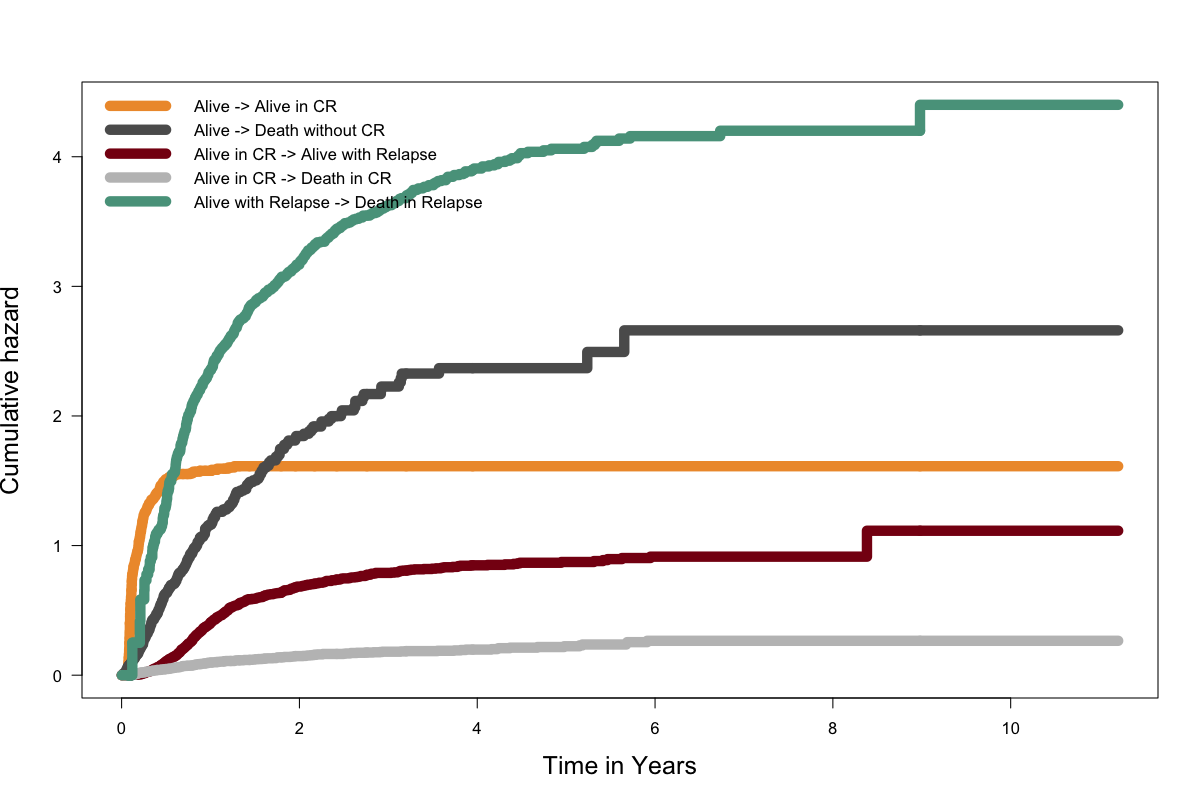

In [16]:
set_notebook_plot_size(12,8)
plot(msf0_data, las = 1,lty=rep(1,6),xlab = "Time in Years",lwd=10,col=c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B"),cex.lab=1.5)

# Transition Probability Estimates : Aalen–Johansen estimator for transition probability matrix of a Markov process with a finite number of states

In [17]:
pt0_data <- probtrans(msf0_data, predt = 0, method = "greenwood",direction = "fo")

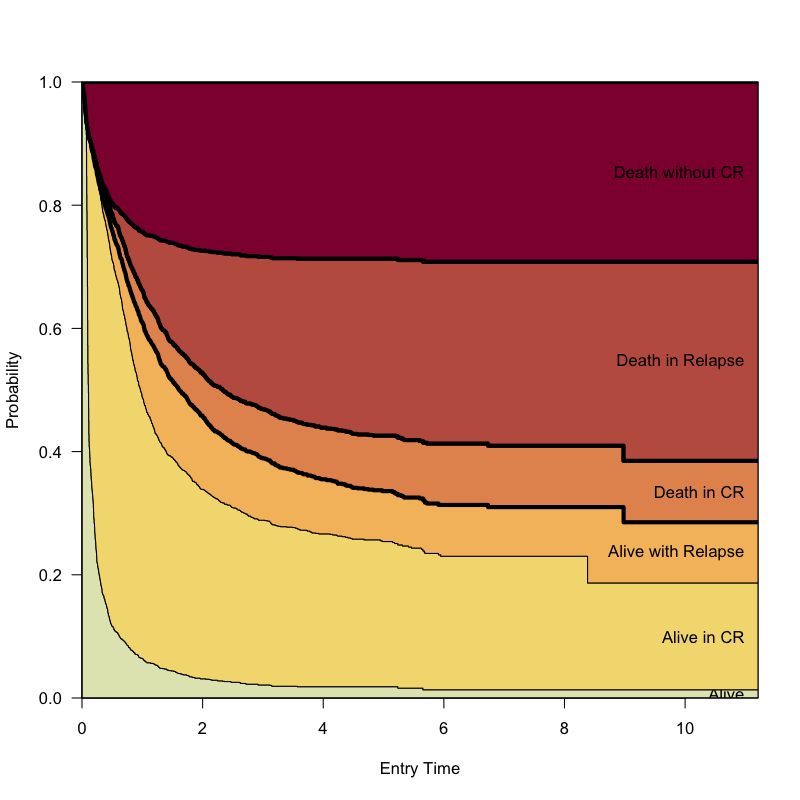

In [18]:
set_notebook_plot_size(8,8)
library("colorspace")
# pt0_data <- probtrans(msf0_data, predt = 0, method = "greenwood",direction = "fo")
statecols <- heat_hcl(6, c = c(80, 30), l = c(30, 90),power = c(1/5, 2))[c(6,5,4,3,2,1)]
ord <- c(1,2,3,4,5,6)
plot(pt0_data,from=1, ord = ord, xlab = "Entry Time",las = 1, type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))

In [19]:
summary(pt0_data,from=3)

An object of class 'probtrans'

Prediction from state 3 (head and tail):

         time pstate1 pstate2 pstate3 pstate4 pstate5 pstate6 se1 se2 se3 se4
1 0.000000000       0       0       1       0       0       0   0   0   0   0
2 0.002737851       0       0       1       0       0       0   0   0   0   0
3 0.005475702       0       0       1       0       0       0   0   0   0   0
4 0.008213552       0       0       1       0       0       0   0   0   0   0
5 0.010951403       0       0       1       0       0       0   0   0   0   0
6 0.013689254       0       0       1       0       0       0   0   0   0   0
  se5 se6
1   0   0
2   0   0
3   0   0
4   0   0
5   0   0
6   0   0

...

          time pstate1 pstate2    pstate3 pstate4   pstate5 pstate6 se1 se2
2698  5.911020       0       0 0.01418799       0 0.9858120       0   0   0
2699  5.947856       0       0 0.01418799       0 0.9858120       0   0   0
2700  6.732375       0       0 0.01359682       0 0.9864032       0   0   0


# Semi-parametric Models : Introduction of the covariates

# I-Components effects

In [20]:
form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_component[1] , sep="")
for (co in expanded_component[2:length(expanded_component)]) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
summary_cox <- (summary(cfull))$coefficients

p_value_threshold <- 0.05
s <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    df <- data.frame(beta = double(),pvalue = double(),Frequency = double())
    for (row in rownames(summary_cox[endsWith(rownames(summary_cox),trans),]))
        df[row,1:3] <- c(summary_cox[row,"coef"],summary_cox[row,5],100*sum(msdata[,row])/dim(msdata)[1])

    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df["names"] <- rownames(df)
    df$names <- str_remove(substr(df$names,1,nchar(df$names)-2),"full_component_")
#     df$Model <- ifelse(df$names %in% gen,"gen",
#                       ifelse(df$names %in% cyto,"cyto",
#                             ifelse(df$names %in% clin, "clin",
#                                   ifelse(df$names %in% demo, "demo",
#                                         ifelse(df$names %in% eln, "eln",
#                                                ifelse(df$names %in% mrd,"mrd","comp"))))))
    df$Model <- "comp"
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    df <- df[order(df$adjusted_pvalue),]
    s[[trans]] <- ggplot(df, aes(x=beta, y=-log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
            geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["pvalue"]<p_value_threshold) | df["beta"] <= -1.5 ,], aes(label=names,fontface=8),size=7)+scale_size_continuous(range = c(3,12)) + 
             scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
            theme(plot.title = element_text(hjust = 0.5,size=21),axis.text=element_text(size=22),axis.title=element_text(size=25,face="bold"))  + theme(legend.position="none") +ggtitle(title)
    if (trans!=".1")
        s[[trans]] <- s[[trans]] + ylab("")
    #+ scale_x_continuous(limits = quantile(df$beta, quantile,na.rm = T))
    }

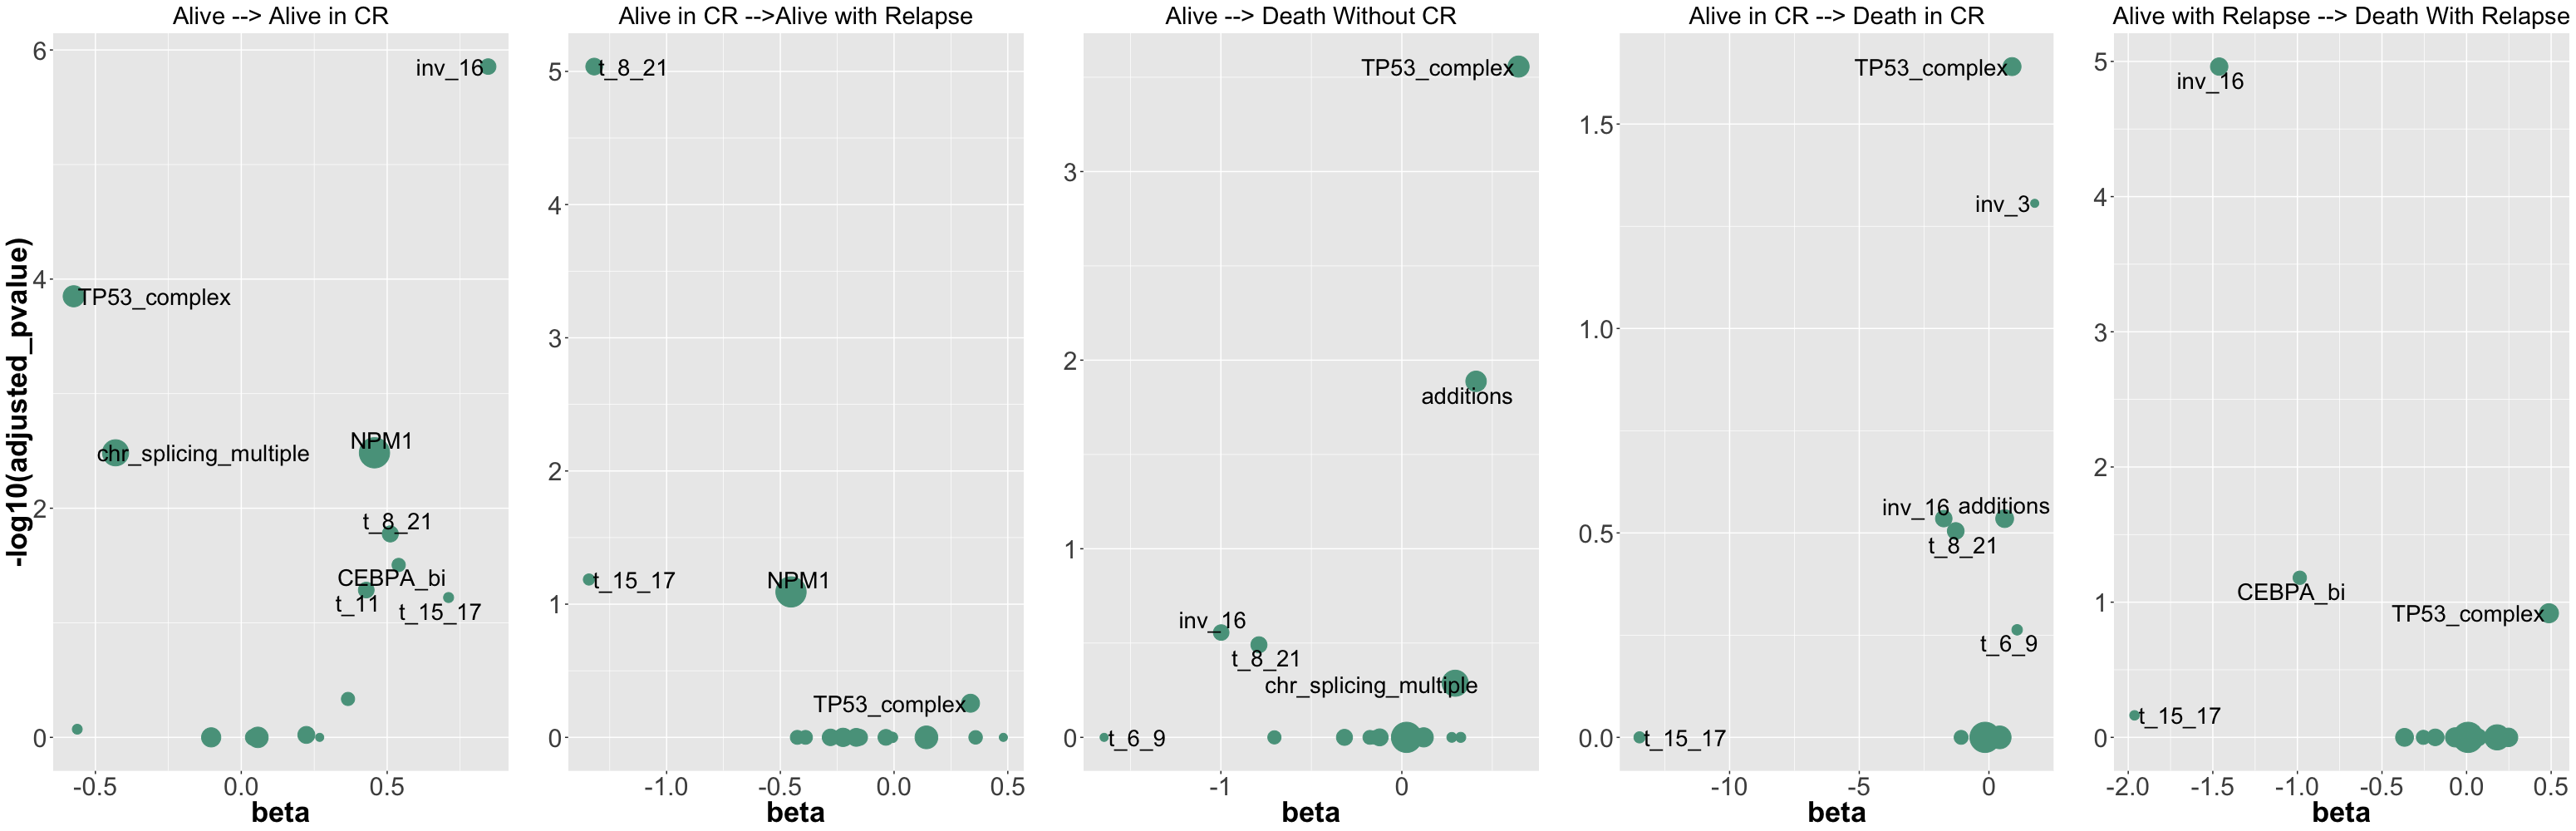

In [21]:
set_notebook_plot_size(31,10)
do.call("grid.arrange",c(s[c(".1",".3",".2",".4",".5")],nrow=1))

# II- Genes and Cytos

In [22]:
form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_genes[1] , sep="")
for (co in c(expanded_genes[2:length(expanded_genes)],expanded_cytos)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
summary_cox <- (summary(cfull))$coefficients

p_value_threshold <- 0.01
s <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    df <- data.frame(beta = double(),pvalue = double(),Frequency = double())
    for (row in rownames(summary_cox[endsWith(rownames(summary_cox),trans),]))
        df[row,1:3] <- c(summary_cox[row,"coef"],summary_cox[row,5],100*sum(msdata[,row])/dim(msdata)[1])

    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df["names"] <- rownames(df)
    df$names <- str_remove(substr(df$names,1,nchar(df$names)-2),"full_component_")
    df$Model <- ifelse(df$names %in% gen,"gen",
                      ifelse(df$names %in% cyto,"cyto",
                            ifelse(df$names %in% clin, "clin",
                                  ifelse(df$names %in% demo, "demo",
                                        ifelse(df$names %in% eln, "eln",
                                               ifelse(df$names %in% mrd,"mrd","comp"))))))
#     df$Model <- "comp"
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    df <- df[order(df$adjusted_pvalue),]
    s[[trans]] <- ggplot(df, aes(x=beta, y=-log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
            geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["pvalue"]<p_value_threshold) | df["beta"] <= -1.5 ,], aes(label=names,fontface=8),size=7)+scale_size_continuous(range = c(3,12)) + 
             scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
            theme(plot.title = element_text(hjust = 0.5,size=21),axis.text=element_text(size=22),axis.title=element_text(size=25,face="bold"))  + theme(legend.position="none") +ggtitle(title)
    if (trans!=".1")
        s[[trans]] <- s[[trans]] + ylab("")
    #+ scale_x_continuous(limits = quantile(df$beta, quantile,na.rm = T))
    }

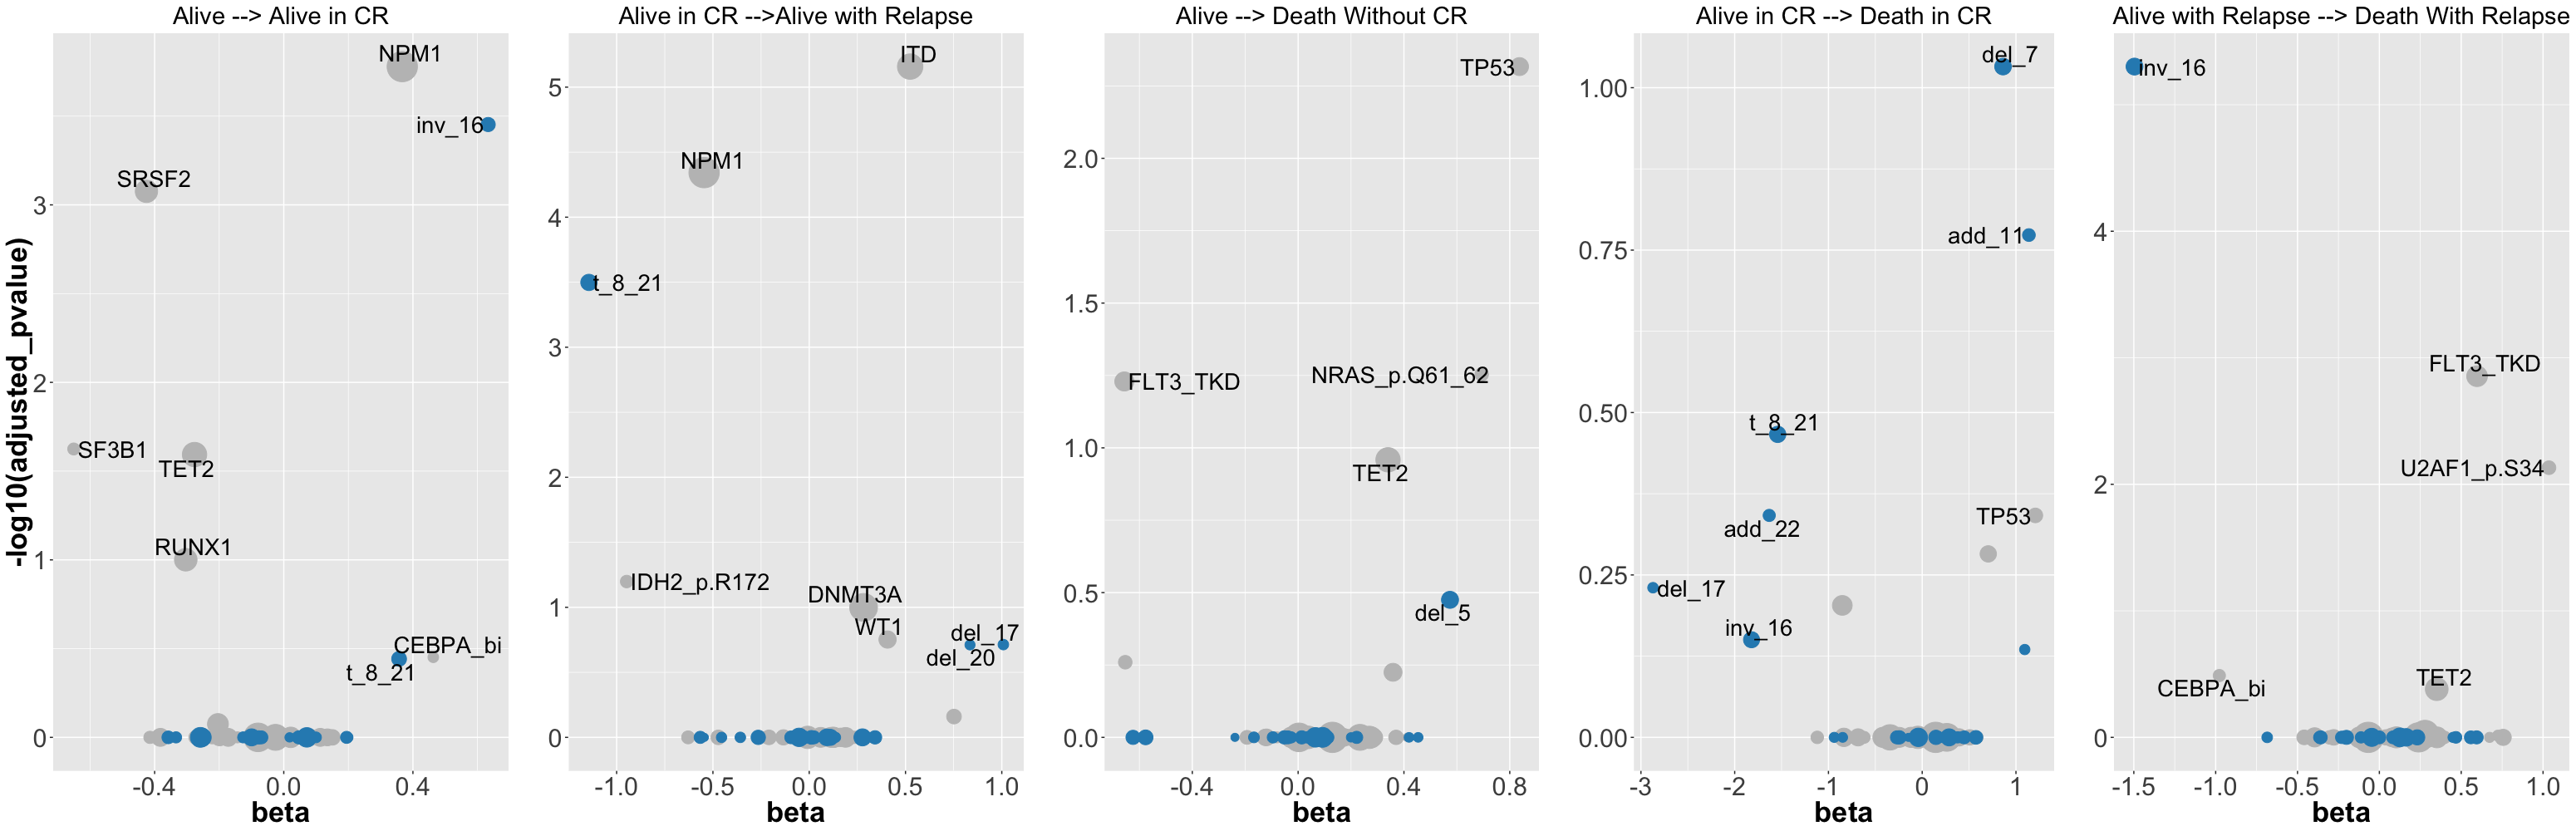

In [23]:
set_notebook_plot_size(31,10)
do.call("grid.arrange",c(s[c(".1",".3",".2",".4",".5")],nrow=1))

# III- Clin and Demo

In [24]:
form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_clin[1] , sep="")
for (co in c(expanded_clin[2:length(expanded_clin)],expanded_demo)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
summary_cox <- (summary(cfull))$coefficients

p_value_threshold <- 0.01
s <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    df <- data.frame(beta = double(),pvalue = double(),Frequency = double())
    for (row in rownames(summary_cox[endsWith(rownames(summary_cox),trans),]))
        df[row,1:3] <- c(summary_cox[row,"coef"],summary_cox[row,5],100*sum(msdata[,row])/dim(msdata)[1])

    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df["names"] <- rownames(df)
    df$names <- str_remove(substr(df$names,1,nchar(df$names)-2),"full_component_")
    df$Model <- ifelse(df$names %in% gen,"gen",
                      ifelse(df$names %in% cyto,"cyto",
                            ifelse(df$names %in% clin, "clin",
                                  ifelse(df$names %in% demo, "demo",
                                        ifelse(df$names %in% eln, "eln",
                                               ifelse(df$names %in% mrd,"mrd","comp"))))))
#     df$Model <- "comp"
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    df <- df[order(df$adjusted_pvalue),]
    s[[trans]] <- ggplot(df, aes(x=beta, y=-log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
            geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["pvalue"]<p_value_threshold) | df["beta"] <= -1,], aes(label=names,fontface=8),size=7)+scale_size_continuous(range = c(3,12)) + 
             scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
            theme(plot.title = element_text(hjust = 0.5,size=21),axis.text=element_text(size=22),axis.title=element_text(size=25,face="bold"))  + theme(legend.position="none") +ggtitle(title)
    if (trans!=".1")
        s[[trans]] <- s[[trans]] + ylab("")
    #+ scale_x_continuous(limits = quantile(df$beta, quantile,na.rm = T))
    }

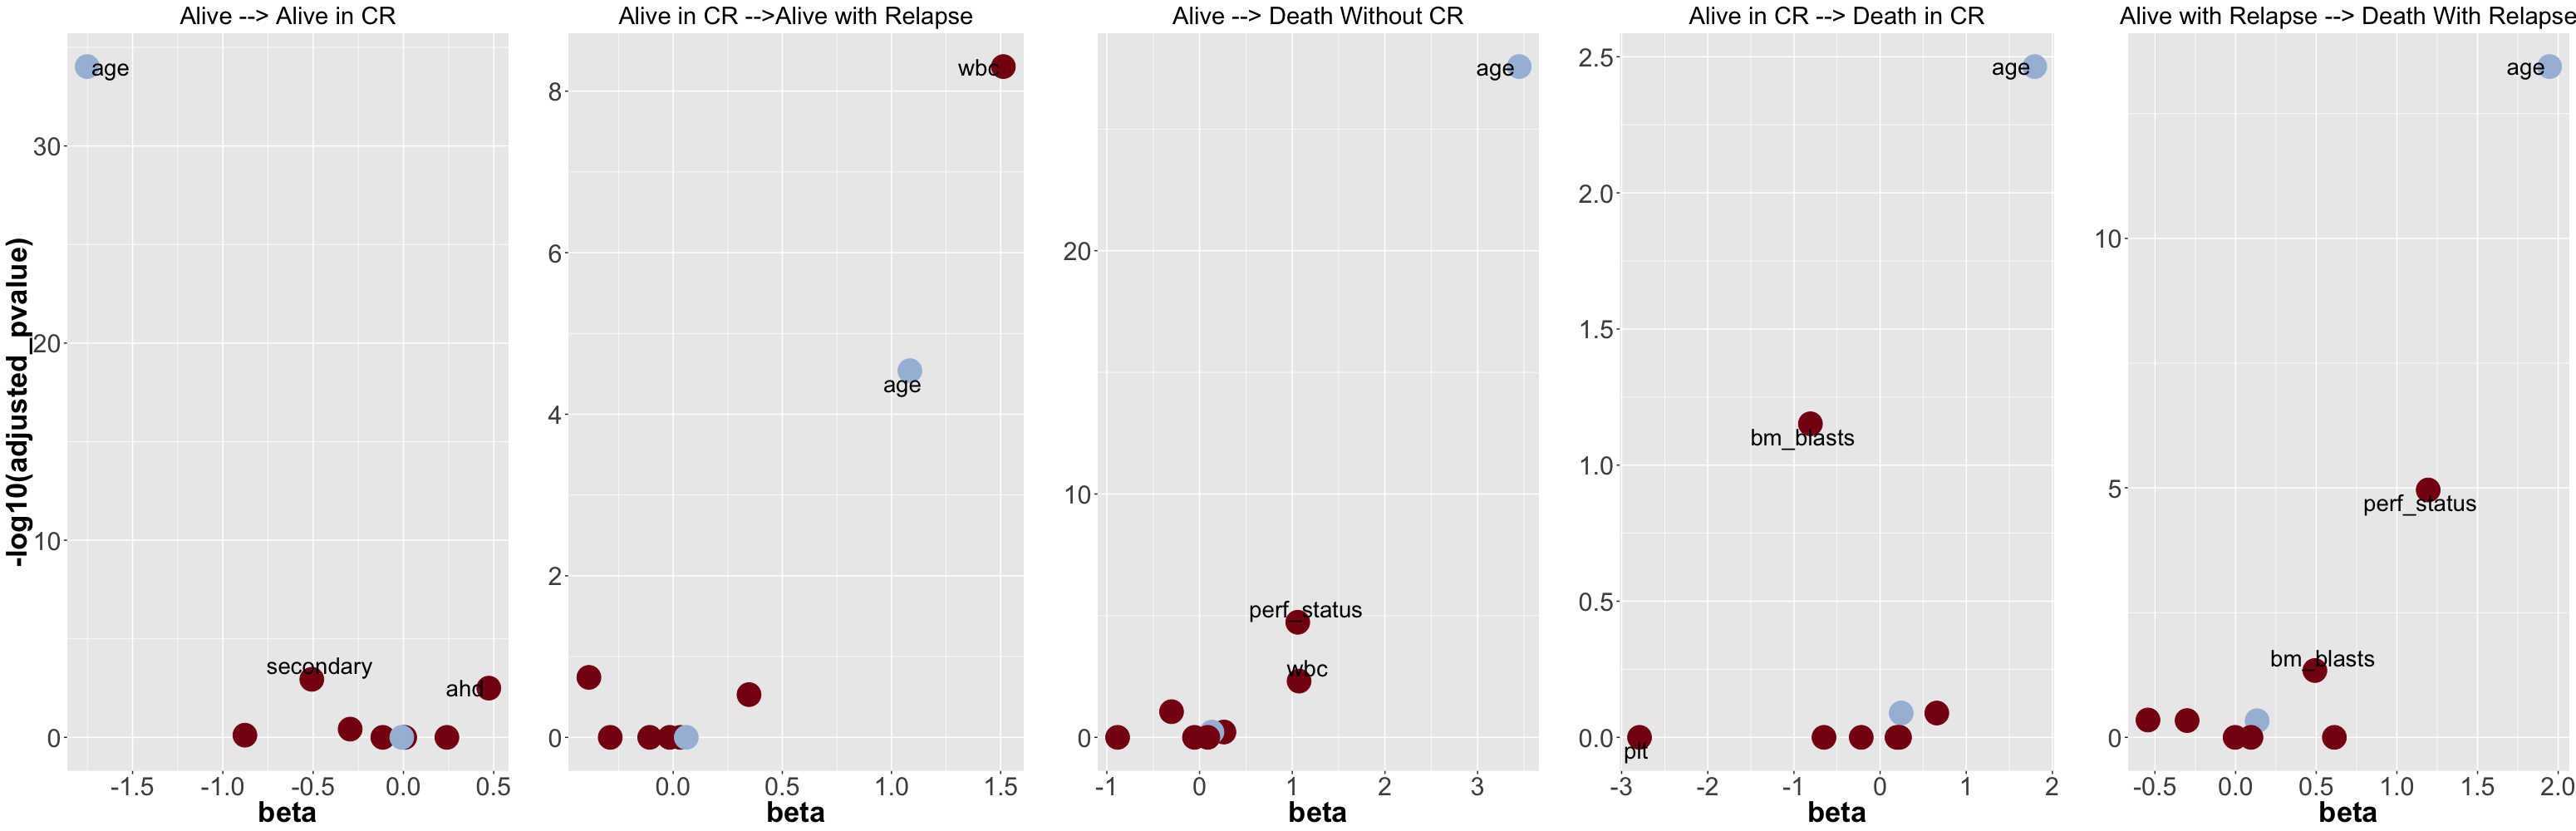

In [25]:
set_notebook_plot_size(31,10)
do.call("grid.arrange",c(s[c(".1",".3",".2",".4",".5")],nrow=1))

# IV- Genes-Cytos-Clin-Demo

In [26]:
form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_genes[1] , sep="")
for (co in c(expanded_genes[2:length(expanded_genes)],expanded_cytos,expanded_clin,expanded_demo)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
summary_cox <- (summary(cfull))$coefficients

p_value_threshold <- 0.01
s <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    df <- data.frame(beta = double(),pvalue = double(),Frequency = double())
    for (row in rownames(summary_cox[endsWith(rownames(summary_cox),trans),]))
        df[row,1:3] <- c(summary_cox[row,"coef"],summary_cox[row,5],100*sum(msdata[,row])/dim(msdata)[1])

    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df["names"] <- rownames(df)
    df$names <- str_remove(substr(df$names,1,nchar(df$names)-2),"full_component_")
    df$Model <- ifelse(df$names %in% gen,"gen",
                      ifelse(df$names %in% cyto,"cyto",
                            ifelse(df$names %in% clin, "clin",
                                  ifelse(df$names %in% demo, "demo",
                                        ifelse(df$names %in% eln, "eln",
                                               ifelse(df$names %in% mrd,"mrd","comp"))))))
#     df$Model <- "comp"
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    df <- df[order(df$adjusted_pvalue),]
    s[[trans]] <- ggplot(df, aes(x=beta, y=-log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
            geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["pvalue"]<p_value_threshold) | df["beta"] <= -1 ,], aes(label=names,fontface=8),size=7)+scale_size_continuous(range = c(3,12)) + 
             scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
            theme(plot.title = element_text(hjust = 0.5,size=21),axis.text=element_text(size=22),axis.title=element_text(size=25,face="bold"))  + theme(legend.position="none") +ggtitle(title)
    if (trans!=".1")
        s[[trans]] <- s[[trans]] + ylab("")
    #+ scale_x_continuous(limits = quantile(df$beta, quantile,na.rm = T))
    }

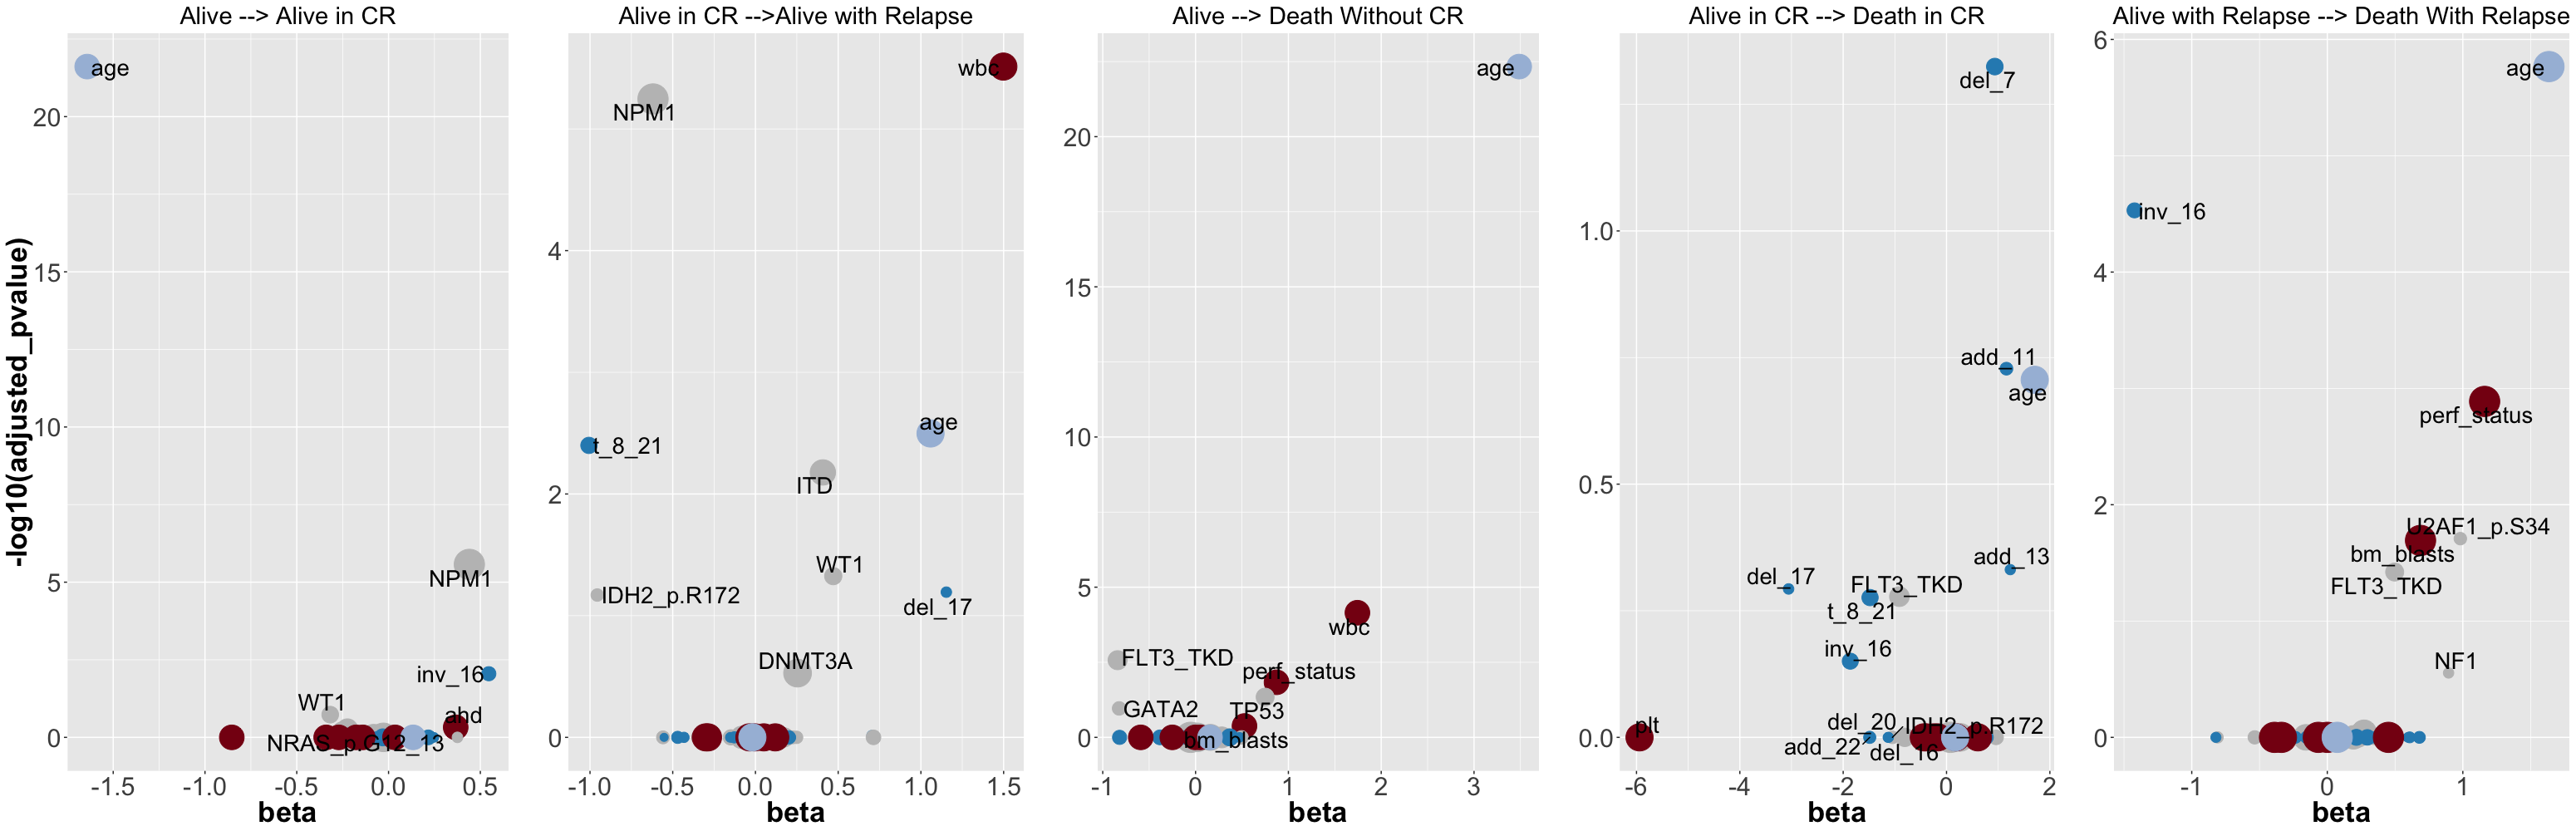

In [27]:
set_notebook_plot_size(31,10)
do.call("grid.arrange",c(s[c(".1",".3",".2",".4",".5")],nrow=1))

In [1]:
msdata

ERROR: Error in eval(expr, envir, enclos): object 'msdata' not found


# V- Comp-Clin-Demo

In [28]:
form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_component[1] , sep="")
for (co in c(expanded_component[2:length(expanded_component)],expanded_clin,expanded_demo)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
summary_cox <- (summary(cfull))$coefficients

p_value_threshold <- 0.01
s <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    df <- data.frame(beta = double(),pvalue = double(),Frequency = double())
    for (row in rownames(summary_cox[endsWith(rownames(summary_cox),trans),]))
        df[row,1:3] <- c(summary_cox[row,"coef"],summary_cox[row,5],100*sum(msdata[,row])/dim(msdata)[1])

    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df["names"] <- rownames(df)
    df$names <- str_remove(substr(df$names,1,nchar(df$names)-2),"full_component_")
#     df$Model <- ifelse(df$names %in% gen,"gen",
#                       ifelse(df$names %in% cyto,"cyto",
#                             ifelse(df$names %in% clin, "clin",
#                                   ifelse(df$names %in% demo, "demo",
#                                         ifelse(df$names %in% eln, "eln",
#                                                ifelse(df$names %in% mrd,"mrd","comp"))))))
    df$Model <- ifelse(df$names %in% clin, "clin",
                                  ifelse(df$names %in% demo, "demo","comp"))
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    df <- df[order(df$adjusted_pvalue),]
    s[[trans]] <- ggplot(df, aes(x=beta, y=-log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
            geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["pvalue"]<p_value_threshold) | df["beta"] <= -1 ,], aes(label=names,fontface=8),size=7)+scale_size_continuous(range = c(3,12)) + 
             scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
            theme(plot.title = element_text(hjust = 0.5,size=21),axis.text=element_text(size=22),axis.title=element_text(size=25,face="bold"))  + theme(legend.position="none") +ggtitle(title)
    if (trans!=".1")
        s[[trans]] <- s[[trans]] + ylab("")
    #+ scale_x_continuous(limits = quantile(df$beta, quantile,na.rm = T))
    }

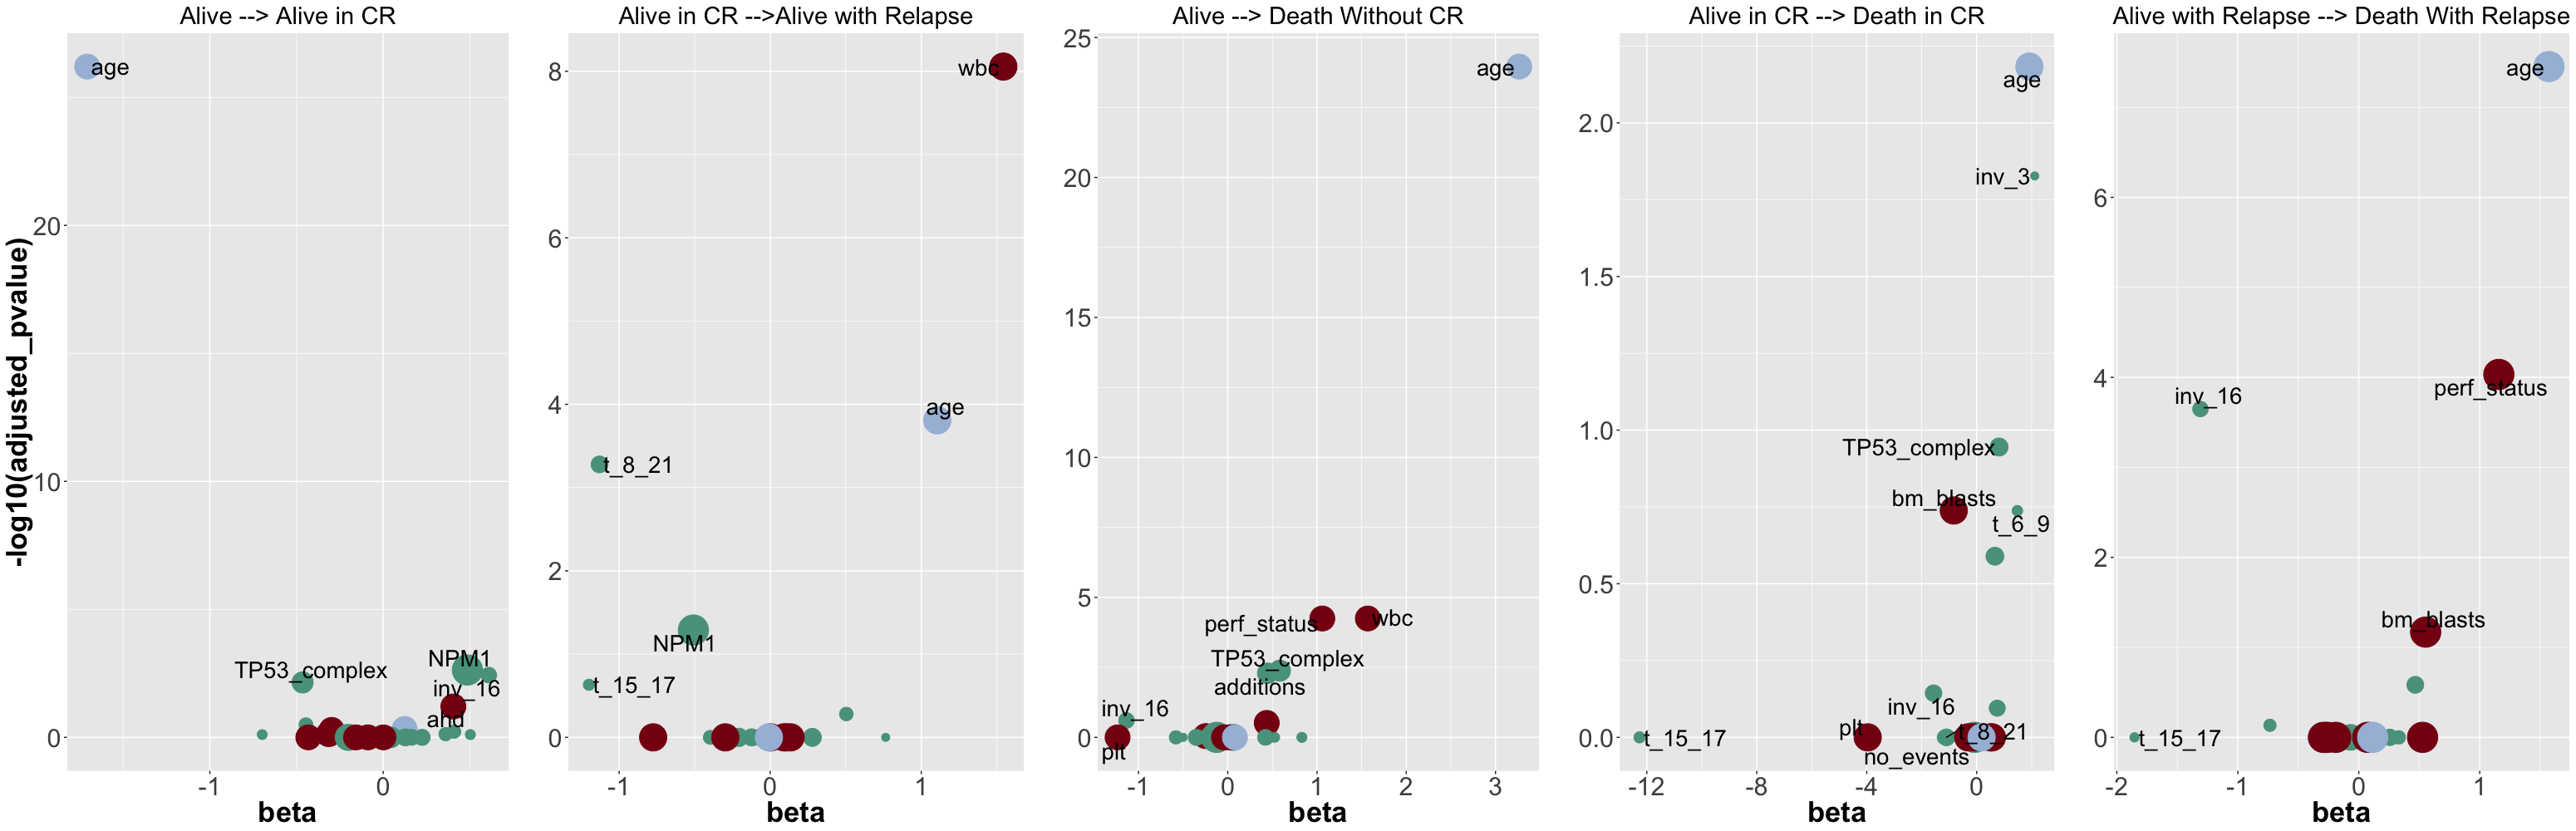

In [29]:
set_notebook_plot_size(31,10)
do.call("grid.arrange",c(s[c(".1",".3",".2",".4",".5")],nrow=1))

# Personalized Estimations

In [40]:
form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_component[1] , sep="")
for (co in c(expanded_component[2:length(expanded_component)])){#,expanded_genes,expanded_cytos,expanded_demo)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")

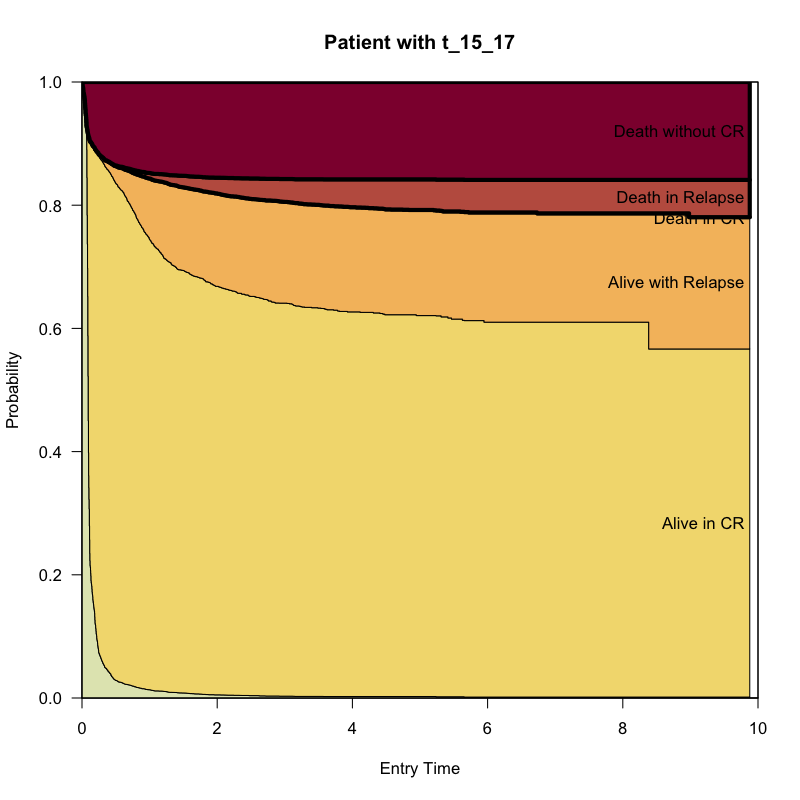

In [42]:
set_notebook_plot_size(30,16)
set_notebook_plot_size(8,8)
# pdf("tmp1.pdf",width=30,height=7)
comp_ordered <- c("full_component_inv_16","full_component_t_8_21","full_component_no_events","full_component_CEBPA_bi","full_component_t_15_17","full_component_NPM1","full_component_t_11",
                  "full_component_t_6_9","full_component_not_assigned","full_component_chr_splicing_1","full_component_DNMT3A_IDH1_2","full_component_WT1","full_component_chr_splicing_multiple",
                  "full_component_additions","full_component_TP53_complex","full_component_inv_3")


comp_ordered <- c("full_component_t_15_17","full_component_inv_16","full_component_t_8_21","full_component_CEBPA_bi","full_component_no_events","full_component_NPM1","full_component_not_assigned","full_component_chr_splicing_1",
                  "full_component_t_11","full_component_t_6_9","full_component_DNMT3A_IDH1_2",
                  "full_component_WT1","full_component_chr_splicing_multiple","full_component_TP53_complex","full_component_inv_3","full_component_additions")

par(mfrow=c(1,1))
for (co in comp_ordered[1]){
    if(co!="full_component_additions"){
        whA <- which(msdata[,co]==1 & rowSums(msdata[,comp])==1)
    }else{
        whA <- which(msdata[,co]==1 & rowSums(msdata[,comp])>1)
    }
    patA <- msdata[rep(whA[1], each=5), c(comp)]
    patA$trans <- 1:5
    attr(patA, "trans") <- tmat_data
    patA <- expand.covs(patA, c(comp), longnames = FALSE)
    patA$strata <- patA$trans
    msfA <- msfit(cfull, patA, trans = tmat_data)

    ptA <- probtrans(msfA, predt = 0)
    ord <- c(1,2,3,4,5,6)

    plot(ptA, ord = c(1,2,3,4,5,6), main = paste("Patient with ",str_remove(co,"full_component_"),sep=""),
    las = 1, xlab = "Entry Time", xlim = c(0, 10),
    type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
    }
# dev.off()

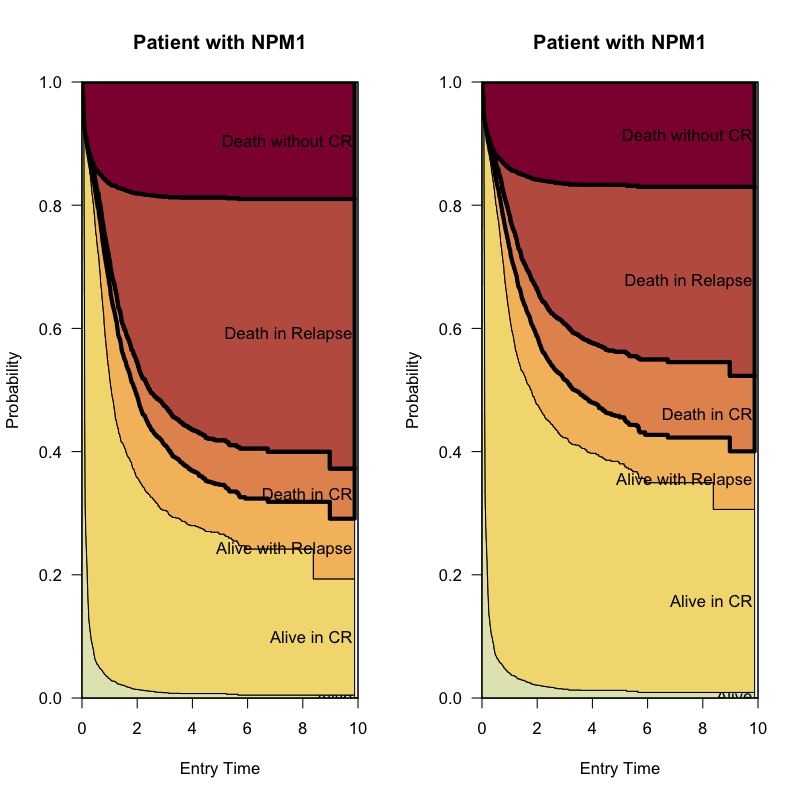

In [88]:
form <- paste("Surv(Tstart, Tstop, status) ~ ITD.1+ITD.2+ITD.3+ITD.4+ITD.5 +" , expanded_component[1] , sep="")
for (co in c(expanded_component[2:length(expanded_component)])){#,expanded_genes,expanded_cytos,expanded_demo)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")

comp_ordered <- c("full_component_inv_16","full_component_t_8_21","full_component_no_events","full_component_CEBPA_bi","full_component_t_15_17","full_component_NPM1","full_component_t_11",
                  "full_component_t_6_9","full_component_not_assigned","full_component_chr_splicing_1","full_component_DNMT3A_IDH1_2","full_component_WT1","full_component_chr_splicing_multiple",
                  "full_component_additions","full_component_TP53_complex","full_component_inv_3")


comp_ordered <- c("full_component_t_15_17","full_component_inv_16","full_component_t_8_21","full_component_CEBPA_bi","full_component_no_events","full_component_NPM1","full_component_not_assigned","full_component_chr_splicing_1",
                  "full_component_t_11","full_component_t_6_9","full_component_DNMT3A_IDH1_2",
                  "full_component_WT1","full_component_chr_splicing_multiple","full_component_TP53_complex","full_component_inv_3","full_component_additions")

par(mfrow=c(1,2))
co <- "full_component_NPM1"

for (i in c(1,0)){
    whA <- which(msdata[,co]==1 & msdata$ITD==i)

    patA <- msdata[rep(whA[1], each=5), c(comp,"ITD")]
    patA$trans <- 1:5
    attr(patA, "trans") <- tmat_data
    patA <- expand.covs(patA, c(comp,"ITD"), longnames = FALSE)
    patA$strata <- patA$trans
    msfA <- msfit(cfull, patA, trans = tmat_data)

    ptA <- probtrans(msfA, predt = 0)
    ord <- c(1,2,3,4,5,6)

    plot(ptA, ord = c(1,2,3,4,5,6), main = paste("Patient with ",str_remove(co,"full_component_"),sep=""),
    las = 1, xlab = "Entry Time", xlim = c(0, 10),
    type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
}

# dev.off()